<a href="https://colab.research.google.com/github/jumarinr/Trabajo_TAE_3/blob/main/TRABAJO_3_TAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de resultados escolares con reducción de la dimensionalidad y agrupamiento

Objetivo: Desarrollar un agrupamiento de instituciones de educación superior.

##Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##Lectura de datos

Se realiza la lectura de los datos.

In [ ]:
#Simples permisos para leer desde drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Link del csv con nuestros datos
college = 'https://drive.google.com/file/d/1iThtFfQ6armnJ2KXMYqQTuxQc-7IoCed/view'
 
# to get the id part of the file
id = college.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('CollegeScorecard.csv') 
df = pd.read_csv('CollegeScorecard.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Se observa una muestra del conjunto de datos sin preprocesamiento.

In [ ]:
df.head()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385


##Preprocesamiento de datos

Con base en el preprocesamiento hecho en https://www.kaggle.com/code/amritasengupta/us-college-scorecard-clustering/notebook, se realiza el siguiente preprocesamiento:

Se toman todas las celdas con el valor "PrivacySuppressed" y se reemplaza por valores NaN ya que son valores omitidos.

In [ ]:
df = df.replace(to_replace = "PrivacySuppressed", value = np.nan)

Se eliminan todas las columnas que sobrepasen el 20% de valores nulos.

In [ ]:
perc = 20.0 # Like N %
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df.dropna(axis = 1, thresh = min_count, inplace = True)

Se observa que se solo quedaron 310 columnas de 1725.

In [ ]:
df.shape

(7804, 310)

Se eliminan las columnas con solo dos y tres valores ya que se consideran categóricas.

In [ ]:
binary_columns = df.nunique()[df.nunique() == 2]

In [ ]:
df.drop(columns = binary_columns.index, inplace = True)

In [ ]:
unique_3_columns = df.nunique()[df.nunique() == 3]

In [ ]:
df.drop(columns = unique_3_columns.index, inplace = True)

Se observa que las columnas se reducen de 310 a 105.

In [ ]:
df.shape

(7804, 105)

Se buscan las columnas que contengan 20 o menos valores únicos para revisar si estas columnas tienen valores categóricos.

In [ ]:
df.nunique()[df.nunique()<=20]

PREDDEG     5
HIGHDEG     5
region     10
LOCALE     12
PCIP29     12
dtype: int64

Se encuentra gracias al diccionario de datos extraído de (Inserten el link de donde sacamos el diccionario de datos) que las columnas "HIGHDEG" y "PREDDEG" son categóricas y, por lo tanto, se eliminan.

In [ ]:
df.drop(columns = ['HIGHDEG', 'PREDDEG'], inplace = True)

Se visualizan las columnas que quedan con las condiciones anteriores.

In [ ]:
df.nunique()[df.nunique()<=20]

region    10
LOCALE    12
PCIP29    12
dtype: int64

Al realizar un análisis exploratorio y con base en el diccionario de datos, se nota que "region" y "LOCALE" son categóricas y, por lo tanto, se eliminan junto con otras columnas que no se consideraron pertinentes para el agrupamiento y análisis.

In [ ]:
df.drop(columns=['region', 'LOCALE', 'DEP_STAT_PCT_IND', 'DEBT_N', 'GRAD_DEBT_N',
                 'WDRAW_DEBT_N', 'FIRSTGEN_DEBT_N', 'NOTFIRSTGEN_DEBT_N',
                 'CUML_DEBT_N', 'CUML_DEBT_P75', 'CUML_DEBT_P25', 'DEP_INC_N',
                 'IND_INC_N', 'PAR_ED_N', 'APPL_SCH_N', 'RPY_3YR_N',
                 'DEBT_MDN_SUPP', 'GRAD_DEBT_MDN_SUPP', 'GRAD_DEBT_MDN10YR_SUPP',
                 'RPY_3YR_RT_SUPP'], inplace = True)

In [ ]:
df.drop(columns = ['UNITID', 'OPEID', 'opeid6', 'INSTNM', 'CITY', 'STABBR', 
                   'ZIP', 'INSTURL', 'NPCURL'], inplace = True)

In [ ]:
df.drop(columns=['st_fips', 'LATITUDE', 'LONGITUDE'], inplace = True)

Al final, el total de columnas luego de la eliminación de columnas es de 71.

In [ ]:
df.shape

(7804, 71)

Ahora se reemplazan los valores nulos con la media de la columna en la que aparecen.

In [ ]:
null_val = df.isnull().sum()[df.isnull().sum() > 0]
null_val.count()

70

In [ ]:
col = null_val.index

for i in col:
    medians = df[i].median()
    df[i] = df[i].fillna(value = medians)

Se observa que no quedan valores nulos en ninguna columna.

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

##Reducción de la dimensionalidad mediante ACP

Luego de la realización del preprocesamiento, se comienza con el proceso de reducción de dimensionalidad por medio del Análisis de Componentes Principales ACP. Este proceso se hizo con base en los realizados en https://www.kaggle.com/code/amritasengupta/us-college-scorecard-clustering/notebook y https://www.cienciadedatos.net/documentos/py19-pca-python.html.

Se toman los valores de nuestra base de datos.

In [ ]:
X = df.values.astype(float)

In [ ]:
X.shape

(7804, 71)

Se genera una instancia del modelo PCA y se entrena con los datos. Se quiere ver cuántos componentes principales son óptimos para explicar la varianza de los datos.

In [ ]:
pca1 = PCA()
pca_fit1 = pca1.fit(X)
reduced_X1 = pca_fit1.transform(X)

# 109 Columns present in X are now represented by 
# 6 Principal components present in reduced_X
print(np.round(reduced_X1, 2))

[[ -7072.21  23229.92  -5954.92 ...     -0.       -0.        0.  ]
 [ 18598.25   4825.78   2334.17 ...     -0.       -0.        0.  ]
 [ -7033.58  11330.42  -3464.71 ...     -0.       -0.        0.  ]
 ...
 [-10345.53  -7091.     1748.46 ...     -0.       -0.       -0.  ]
 [-10345.53  -7091.     1748.46 ...     -0.       -0.       -0.  ]
 [-10345.53  -7091.     1748.46 ...     -0.       -0.       -0.  ]]


Se muestra la varianza explicada por cada componente principal.

In [ ]:
var_explained = pca1.explained_variance_ratio_
print(np.round(var_explained, 2))

[0.63 0.12 0.1  0.05 0.05 0.03 0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.  ]


Se presenta la varianza explicada acumulada.

In [ ]:
var_explained_cumulative = np.cumsum(np.round(
    pca1.explained_variance_ratio_, decimals = 4) * 100)
print(var_explained_cumulative)

[62.91 75.19 85.3  90.28 94.84 97.82 99.22 99.56 99.82 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99]


A continuación, se expone el gráfico de codo para encontrar número óptimo de componentes principales.

(-1.0, 15.0)

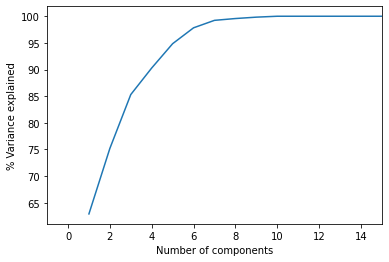

In [ ]:
plt.plot( range(1, len(var_explained_cumulative)+1), var_explained_cumulative )
plt.xlabel('Number of components')
plt.ylabel('% Variance explained')
plt.xlim(-1,15)

Al observar la gráfica, se nota que el número óptimo de componentes principales es 6.

Ahora, se entrena un modelo Pipeline, el cual es un modelo compuesto por un escalador de datos (StandardScaler) y por un modelo PCA que calculará 6 componentes principales y se extraerá únicamente el modelo PCA entrenado.

In [ ]:
from sklearn.pipeline import make_pipeline

# Pipeline comparte los métodos de los diferentes modelos de Sklearn
ACP_pipe = make_pipeline(StandardScaler(), PCA(n_components = 6))
# Aplica método fit del scaler y del PCA a la base de datos
ACP_pipe.fit(df)

# Se extrae el modelo entrenado deseado
modelo_ACP = ACP_pipe.named_steps['pca']

Se crea la matriz de componentes principales a usar en el agrupamiento.

In [ ]:
# Proyección de las observaciones de entrenamiento
components = modelo_ACP.transform(X=df)
col = [[f'PC{i}' for i in range(1, len(components[0])+1)]]
components = pd.DataFrame(
    components,
    columns = col,
    index   = df.index
)
components.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,PC1,PC2,PC3,PC4,PC5,PC6
0,31422.505437,-27268.666051,-9825.667328,3330.867757,11832.938955,-6712.612816
1,35655.777347,-21138.220284,-20315.497945,8237.333197,14713.495059,-7935.827452
2,25884.957769,-21493.876009,-13878.311442,4681.319989,10337.523311,-6250.615269
3,35566.118730,-22801.131123,-21472.519368,7489.931579,12841.597186,-9012.153121
4,28002.785863,-23571.075681,-8684.828221,3736.114523,9948.328477,-5289.815575


##Agrupamiento

El agrupamiento se realizará utilizando el algoritmo KMeans. 

A continuación, se presenta una gráfica que permite observar la inercia (que indica que tan bien realiza el agrupamiento el modelo) y el número de clusters, esto con el fin de obtener el número óptimo de clusters.

In [ ]:
v = components.values

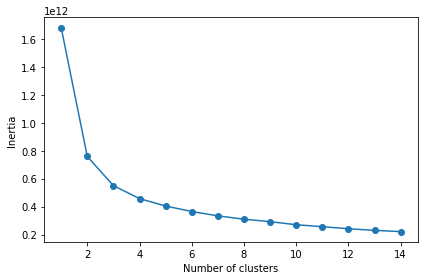

In [ ]:
# Finding the best number of clusters based on the inertia value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertiaValue = []
for i in range(1, 15):
    km = KMeans(n_clusters = i, 
                init = 'random', 
                n_init = 10, 
                max_iter = 300,
                tol = 1e-04,
                random_state = 0)
    
    km.fit(v)
    inertiaValue.append(km.inertia_)
    
plt.plot(range(1, 15), inertiaValue, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

Se puede observar que el número óptimo de clusters es 4, así que se prosigue a entrenar el modelo de KMeans con 4 clusters.

In [ ]:
# Defining the K-Means object for best number of clusters. n=4 in this case
km = KMeans(n_clusters = 4, 
            init = 'k-means++', 
            n_init = 10, 
            max_iter = 300,
            tol = 1e-04,
            random_state = 11)

Se predicen los grupos que da como resultado el algoritmo de KMeans.

In [ ]:
predictedCluster = km.fit_predict(v)
print(predictedCluster)
print('Inertia:', km.inertia_)

[2 2 2 ... 0 0 0]
Inertia: 457199449144.7728


In [ ]:
components['PredictedClusterID'] = predictedCluster

Seguidamente se presenta una gráfica de dispersión que muestra el agrupamiento tendiendo en cuenta las componentes principales PC3 y PC4.

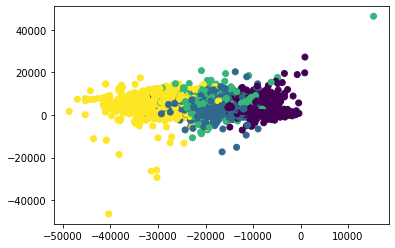

In [ ]:
%matplotlib inline
plt.scatter(x = components['PC3'], y = components['PC4'], c = components['PredictedClusterID'])

In [ ]:
df['PredictedClusterID'] = predictedCluster
df.head()

,NUMBRANCH,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,...,APPL_SCH_PCT_GE4,DEP_INC_AVG,IND_INC_AVG,DEBT_MDN,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,FIRSTGEN_DEBT_MDN,NOTFIRSTGEN_DEBT_MDN,GRAD_DEBT_MDN10YR,PredictedClusterID
0,1,0.0397,0.0199,0.0116,0.0000,0.0000,0.0348,0.0348,0.0,0.1490,...,0.476052849,33054.68926,9473.437492,19500,33611.5,14250,18186,20250,373.1565536,2
1,1,0.0000,0.0000,0.0000,0.0018,0.0456,0.0000,0.0099,0.0,0.0862,...,0.177436554,59852.54783,26714.10942,16250,23117,11886,15541,16000,256.6460899,2
2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0411,0.0,0.0000,...,0.218446602,35816.19451,21767.30931,10500,26995,9500,11692,12698,299.6998398,2
3,1,0.0000,0.0000,0.0000,0.0000,0.0318,0.0000,0.0273,0.0,0.0173,...,0.158221303,63370.50758,26499.31173,16500,24738,10500,16446,16500,274.6425129,2
4,1,0.0000,0.0000,0.0000,0.0000,0.0733,0.0000,0.0450,0.0,0.2150,...,0.399108138,32377.76273,7347.093365,15854.5,33452,12500,15000,15000,371.3857766,2


In [ ]:
df['PredictedClusterID'].value_counts()

1    2715
0    2464
2    1578
3    1047
Name: PredictedClusterID, dtype: int64

In [ ]:
G0 = df[df['PredictedClusterID'] == 0]
G1 = df[df['PredictedClusterID'] == 1]
G2 = df[df['PredictedClusterID'] == 2]
G3 = df[df['PredictedClusterID'] == 3]

In [ ]:
pd.set_option('display.max_columns', None)

## Caracterización de grupos

A continuación se muestran las variables utilizadas en el agrupamiento.

NUMBRANCH: Cantidad de sedes.

PCIP: porcentaje de graduados (01: Agricultura, 03: Recursos naturales, 04: Arquitectura, 05: Étnico-cultural, 09: Comunicación, 10: Tecnologías de la comunicación, 11: Ciencias de la computación, 12: Servicios culinarios, 13: Educación, 14: Ingeniería, 15: Tecnologías de la ingeniería, 16: Lenguaje, 19: Ciencias humanas, 22: Estudios legales, 23: Lenguaje inglés, 24: Humanidades, 25: Bibliotecología, 26: Ciencias biológicas, 27: Matemáticas, 29: Tecnología militar, 30: Estudios multidisciplinares, 31: Recreación, 38: Filosofía y Religión, 39: Teología, 40: Ciencias físicas, 41: Tecnologías en ciencias, 42: Psicología, 43: Servicios de protección, 44: Servicio social, 45: Ciencia social, 46: Construcción, 47: Tecnologías de reaparación y mecánica, 48: Producción de precisión, 49: Transporte, 50: Artes visuales y escénicas, 51: Profesionales de la salud, 52: Negocios, 54: Historia). --

UGDS: Matriculación de estudiantes que buscan un título universitario. --

UGDS_: Matriculación de estudiantes que buscan un título universitario por raza (WHITE: Blancos, BLACK: Negros, HISP: Hispanos, ASIAN: Asiáticos, AIAN: Indio americano/Nativo de Alaska, NHPI: Nativo de Hawai/Islas del Pacífico, 2MOR: Dos o máss razas, NRA: Extranjeros no residentes, UNKN: Desconocido). --

PPTUG_EF: Porcentaje de estudiantes a tiempo parcial de pregrado que buscan un título o un certificado. (Tener en cuenta para Colombia)

TUITFTE: Ingresos netos de matrícula por estudiante equivalente a tiempo completo.

INEXPFTE: Gastos de instrucción por estudiante equivalente a tiempo completo.

PCTPELL: Porcentaje de estudiantes que reciben una beca Pell (Becas Federales).

PCTFLOAN: Porcentaje de todos los estudiantes federales de pregrado que reciben un préstamo federal para estudiantes.

UG25abv: Porcentaje de estudiantes de 25 años o más. --

CDR3: Tasa de impago de la cohorte a tres años. --

Las variables que se tendrán en cuenta para la caracterización son las siguientes: 

In [ ]:
G0_summary = G0.describe().drop(columns=['NUMBRANCH','PPTUG_EF','TUITFTE',
                                         'INEXPFTE','PCTPELL','PCTFLOAN',
                                         'PredictedClusterID'])
G0_summary

,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UG25abv,CDR3
count,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.00000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000
mean,0.003130,0.000947,0.000207,0.000504,0.002844,0.004097,0.018801,0.289327,0.013331,0.001730,0.020249,0.000914,0.00961,0.003949,0.003634,0.087002,0.000128,0.002967,0.000653,0.000105,0.007813,0.001414,0.001333,0.008979,0.001486,0.001077,0.002883,0.021772,0.003477,0.004598,0.015765,0.034239,0.015824,0.011545,0.008031,0.286146,0.058446,0.000389,2326.793222,0.401676,0.230810,0.244330,0.032926,0.021985,0.005797,0.017522,0.006398,0.027235,0.444534,0.149284
std,0.024665,0.007031,0.002056,0.007264,0.034446,0.039326,0.054654,0.431559,0.053636,0.015077,0.070285,0.006170,0.03484,0.024226,0.043181,0.170296,0.002591,0.017510,0.003169,0.004876,0.032864,0.010191,0.031479,0.090433,0.020285,0.012507,0.014680,0.053813,0.018597,0.024618,0.063793,0.096803,0.056063,0.084464,0.043851,0.332625,0.096323,0.002544,5312.090098,0.293215,0.252971,0.299704,0.089065,0.105589,0.048817,0.030033,0.030255,0.065618,0.164516,0.112107
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002100,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119.000000,0.124125,0.038575,0.030300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344300,0.044500
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007700,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164650,0.012350,0.000000,371.500000,0.392700,0.123100,0.096400,0.009850,0.002500,0.000000,0.009100,0.000000,0.007900,0.425650,0.161000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020025,0.969250,0.000000,0.000000,0.011625,0.000000,0.00000,0.000000,0.000000,0.107175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023400,0.000000,0.000000,0.000000,0.019125,0.000000,0.000000,0.000000,0.426025,0.090700,0.000000,1715.750000,0.624700,0.345725,0.354625,0.025150,0.006900,0.001900,0.023700,0.001100,0.027800,0.535325,0.222000
max,1.000000,0.150500,0.046700,0.213700,1.000000,1.000000,0.984700,1.000000,1.000000,0.512400,1.000000,0.181800,1.00000,1.000000,0.950000,1.000000,0.121200,0.390200,0.058400,0.241800,0.626300,0.349100,1.000000,1.000000,0.952400,0.494300,0.242900,1.000000,0.363600,0.412700,1.000000,1.00

Al revisar el resumen del grupo 0, se puede observar que aquellas universidades que se encuentran en este grupo han graduado, en promedio, al 30% de los estudiantes de carreras relacionadas con servicios culinarios y al 29% de los estudiantes de carreras relacionadas con la salud. En estas universidades hay en promedio 2324 estudiantes que buscan graduarse y de estos el 40% son blancos, el 23% son afroamericanos y el 24% son hispanos. En estas universidades, el 44% de los estudiantes tienen 25 años o más en promedio. En estas universidades la tasa de impago de la cohorte a tres años es de un 15% en promedio. Todos estos datos son aproximados.

In [ ]:
G1_summary = G1.describe().drop(columns=['NUMBRANCH','PPTUG_EF','TUITFTE',
                                         'INEXPFTE','PCTPELL','PCTFLOAN',
                                         'PredictedClusterID'])
G1_summary

,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UG25abv,CDR3
count,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.00000,2715.000000,2715.00000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000,2715.000000
mean,0.003921,0.001017,0.000490,0.000527,0.005441,0.005736,0.016774,0.27223,0.009120,0.00230,0.013148,0.000832,0.002784,0.007065,0.001293,0.035254,0.000043,0.004389,0.000595,0.000003,0.002002,0.004489,0.004783,0.036288,0.000891,0.000533,0.008455,0.014831,0.001941,0.003277,0.007984,0.029172,0.009227,0.004968,0.017326,0.287344,0.047609,0.001053,999.198711,0.583278,0.157376,0.113880,0.024501,0.010003,0.003879,0.021655,0.009752,0.043088,0.449963,0.129695
std,0.041006,0.012891,0.019379,0.009253,0.058040,0.066811,0.077595,0.43142,0.051639,0.03132,0.065666,0.009492,0.024015,0.055377,0.007817,0.116838,0.001117,0.035804,0.004197,0.000116,0.017085,0.046308,0.060236,0.181583,0.006452,0.007073,0.060597,0.047112,0.010733,0.022412,0.051092,0.127973,0.064705,0.056231,0.105070,0.370071,0.114985,0.006695,2937.104485,0.260466,0.191032,0.152226,0.059892,0.041019,0.019897,0.031552,0.051268,0.104387,0.191776,0.093684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.420800,0.033300,0.022600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.321850,0.050500
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097000,0.000000,0.000000,236.000000,0.566900,0.099250,0.068500,0.012000,0.002700,0.000000,0.015500,0.000000,0.014600,0.413500,0.132000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.85470,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552650,0.032250,0.000000,473.500000,0.794300,0.197050,0.131750,0.020800,0.006600,0.001400,0.028300,0.000000,0.031300,0.576900,0.197000
max,1.000000,0.445000,1.000000,0.307700,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,0.391300,1.000000,1.000000,0.133300,1.000000,0.052200,1.000000,0.081600,0.004600,0.417100,1.000000,1.000000,1.000000,0.146100,0.252700,0.909100,0.519200,0.275100,0.449800,1.000000,1.000000,1.0000

Al ver el resumen de los datos del grupo 1, se puede encontrar con que estas universidades han graduado, en promedio, el 19% de estudiantes pertenecientes a carreras relacionadas con la salud y el 17% de estudiantes pertenecientes a carreras relacionadas con negocios. Estas universidades tienen en promedio 2926 estudiantes, de los cuales el 52% son blancos, el 20% son afroamericanos y el 11% son hispanos. De todos estos estudiantes, el 45% tienen 25 años o más en promedio. La tasa de impago de la cohorte a tres años es del 14% en promedio. Todos estos datos son aproximados.

In [ ]:
G2_summary = G2.describe().drop(columns=['NUMBRANCH','PPTUG_EF','TUITFTE',
                                         'INEXPFTE','PCTPELL','PCTFLOAN',
                                         'PredictedClusterID'])
G2_summary

,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UG25abv,CDR3
count,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000
mean,0.002470,0.003966,0.001021,0.001822,0.013658,0.004891,0.060906,0.019351,0.035539,0.008175,0.034378,0.003592,0.004194,0.010908,0.011489,0.026686,0.000009,0.021107,0.004375,0.000082,0.014953,0.012968,0.004386,0.022276,0.006031,0.000084,0.027652,0.045688,0.012030,0.025940,0.001525,0.019283,0.000929,0.002400,0.051845,0.186942,0.167066,0.007703,2931.466730,0.517020,0.198468,0.105691,0.028727,0.008595,0.002975,0.024870,0.015278,0.073163,0.450361,0.138309
std,0.013103,0.019749,0.006999,0.018793,0.026634,0.035472,0.125397,0.122187,0.075140,0.036940,0.097540,0.013523,0.028132,0.063313,0.022333,0.088405,0.000215,0.039648,0.009706,0.002115,0.056870,0.036529,0.029859,0.122846,0.015224,0.001338,0.051349,0.081425,0.038845,0.055154,0.023446,0.130381,0.013037,0.036559,0.143982,0.286907,0.214348,0.016212,7072.906854,0.246071,0.212415,0.126557,0.053982,0.029443,0.009506,0.024726,0.034543,0.125323,0.266172,0.068468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020250,0.000000,336.000000,0.329725,0.059125,0.030150,0.007000,0.001900,0.000000,0.011900,0.000000,0.011300,0.220500,0.083000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083050,0.107250,0.000000,592.500000,0.565150,0.104400,0.068500,0.012000,0.003500,0.000600,0.018500,0.000700,0.023750,0.413500,0.141000
75%,0.000000,0.000000,0.000000,0.000000,0.018775,0.000000,0.042950,0.000000,0.048000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016300,0.005475,0.000000,0.031800,0.005100,0.000000,0.000600,0.000000,0.000000,0.000000,0.004200,0.000000,0.048825,0.067575,0.000000,0.029250,0.000000,0.000000,0.000000,0.000000,0.044575,0.196975,0.213700,0.010650,2170.500000,0.704650,0.253125,0.124425,0.027600,0.007300,0.002600,0.031400,0.016875,0.069525,0.692800,0.190000
max,0.186500,0.415400,0.152200,0.692300,0.233800,0.824000,1.000000,1.000000,1.000000,0.548900,0.924600,0.375600,0.980600,1.000000,0.166700,1.000000,0.005800,0.278000,0.100500,0.074000,1.000000,0.636400,0.757600,1.000000,0.199400,0.036100,1.000000,1.000000,0.581400,0.422500,0.772

En este resumen sobre las universidades en el grupo 2, se nota que estas universades han graduado al 20% de los estudiantes pertenecientes a las carreras relacionadas con la salud y al 15% de los estudiantes pertenecientes a carreras relacionadas con los negocios. Tienen en promedio a 3612 estudiantes, de estos, el 65% son blancos. De todos los estudiantes que se encuentran en promedio, el 24% son estudiantes de 25 años o más. La tasa de impago de la cohorte a tres años es del 6%. Todos estos datos son aproximados.

In [ ]:
G3_summary = G3.describe().drop(columns=['NUMBRANCH','PPTUG_EF','TUITFTE',
                                         'INEXPFTE','PCTPELL','PCTFLOAN',
                                         'PredictedClusterID'])
G3_summary

,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UG25abv,CDR3
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.0,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,0.005380,0.007177,0.006829,0.003299,0.037137,0.005756,0.019719,0.009688,0.049404,0.030342,0.004739,0.007856,0.009020,0.007407,0.023578,0.032089,0.000028,0.042794,0.008917,0.0,0.013312,0.018701,0.006991,0.008481,0.011212,0.000359,0.049989,0.018281,0.012751,0.050291,0.000322,0.002047,0.000339,0.005537,0.086542,0.195589,0.151211,0.015011,3606.808500,0.653592,0.086276,0.077669,0.045217,0.004961,0.002130,0.026085,0.035956,0.058028,0.242246,0.058889
std,0.040493,0.025713,0.056874,0.010720,0.072665,0.051444,0.065662,0.087930,0.068238,0.098506,0.021431,0.013289,0.041954,0.068517,0.029540,0.110075,0.000554,0.054342,0.012516,0.0,0.039436,0.043182,0.024147,0.045735,0.017150,0.005592,0.053161,0.048388,0.039322,0.073427,0.009525,0.037843,0.008821,0.055742,0.207718,0.299875,0.153403,0.018143,5674.113641,0.178463,0.094845,0.068245,0.060162,0.008582,0.004281,0.036158,0.053715,0.079860,0.225479,0.039371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000600,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017350,0.000000,666.500000,0.561850,0.035800,0.033800,0.012000,0.001500,0.000000,0.014100,0.003450,0.013900,0.064700,0.035000
50%,0.000000,0.000000,0.000000,0.000000,0.018900,0.000000,0.006700,0.000000,0.020500,0.000000,0.000000,0.000000,0.000000,0.000000,0.016000,0.000000,0.000000,0.032600,0.004500,0.0,0.000000,0.000000,0.000000,0.000000,0.003900,0.000000,0.043700,0.000000,0.000000,0.019400,0.000000,0.000000,0.000000,0.000000,0.028000,0.077700,0.133500,0.010700,1655.000000,0.685400,0.061000,0.060900,0.024200,0.002700,0.000900,0.022300,0.016800,0.033500,0.157000,0.054000
75%,0.000000,0.006000,0.000000,0.001300,0.057050,0.000000,0.018550,0.000000,0.080500,0.001500,0.000000,0.010900,0.000000,0.000000,0.035150,0.021300,0.000000,0.067100,0.013900,0.0,0.014900,0.029600,0.007900,0.000000,0.016150,0.000000,0.077750,0.014750,0.015600,0.076600,0.000000,0.000000,0.000000,0.000000,0.064450,0.217900,0.219350,0.024050,3522.500000,0.792750,0.100400,0.095950,0.052700,0.005400,0.002300,0.032950,0.044600,0.078050,0.389950,0.075000
max,0.955900,0.564100,1.000000,0.154100,1.000000,0.968100,1.000000,1.000000,0.585100,1.000000,0.290400,0.105100,1.000000,1.000000,0.250000,1.000000,0.013700,1.000000,0.125000,0.0,1.000000,1.000000,0.700300,0.713300,0.175800,0.142300,0.386800,0.614600,1.000000,1.000000,0.307700,1.000000,0.282100,1.000000,1.000000

Según el resumen de los datos del grupo 3, podemos ver que las universidades que se encuentran en este grupo han graduado, en promedio, al 27% de los estudiantes que pertenecen a las carreras relacionadas con servicios culinarios y al 29% de los estudiantes pertenecientes a las carreras relacionadas con la salud. En promedio estas universidades tienen a 1000 estudiantes, de los cuales el 58% son blancos, el 16% son afroamericanos y el 11% son hispanos. De todos los estudiantes de estas universidades, el 45% son estudiantes con 25 años o más. La tasa de impago del cohorte a tres años es del 13%. Todos estos datos son aproximados.

# ¿Por que es buena opción cada grupo?

In [ ]:
sum_mean_0 = G0_summary[1:2].drop(['PCIP12','PCIP51','UGDS',	'UGDS_WHITE',	'UGDS_BLACK',	'UGDS_HISP',	'UGDS_ASIAN',	'UGDS_AIAN',	'UGDS_NHPI',	'UGDS_2MOR',	'UGDS_NRA',	'UGDS_UNKN',	'UG25abv',	'CDR3'], axis=1).sum(axis=1)
sum_mean_0

mean    0.373874
dtype: float64

In [ ]:
sum_mean_1 = G1_summary[1:2].drop(['PCIP51','PCIP52','UGDS',	'UGDS_WHITE',	'UGDS_BLACK',	'UGDS_HISP',	'UGDS_ASIAN',	'UGDS_AIAN',	'UGDS_NHPI',	'UGDS_2MOR',	'UGDS_NRA',	'UGDS_UNKN',	'UG25abv',	'CDR3'], axis=1).sum(axis=1)
sum_mean_1

mean    0.530185
dtype: float64

In [ ]:
sum_mean_2 = G2_summary[1:2].drop(['PCIP51','PCIP52','UGDS',	'UGDS_WHITE',	'UGDS_BLACK',	'UGDS_HISP',	'UGDS_ASIAN',	'UGDS_AIAN',	'UGDS_NHPI',	'UGDS_2MOR',	'UGDS_NRA',	'UGDS_UNKN',	'UG25abv',	'CDR3'], axis=1).sum(axis=1)
sum_mean_2

mean    0.52431
dtype: float64

In [ ]:
sum_mean_3 = G3_summary[1:2].drop(['PCIP12','PCIP51','UGDS',	'UGDS_WHITE',	'UGDS_BLACK',	'UGDS_HISP',	'UGDS_ASIAN',	'UGDS_AIAN',	'UGDS_NHPI',	'UGDS_2MOR',	'UGDS_NRA',	'UGDS_UNKN',	'UG25abv',	'CDR3'], axis=1).sum(axis=1)
sum_mean_3

mean    0.752847
dtype: float64

In [ ]:
G2_summary['PCIP14']['mean']/((G0_summary['PCIP14']['mean']+G1_summary['PCIP14']['mean']+G2_summary['PCIP14']['mean']+G3_summary['PCIP14']['mean']))

0.19213895363341943

In [ ]:
bes_options={}

for i in G2_summary.columns[:38]:
  r0 = G0_summary[i]['mean']/((G0_summary[i]['mean']+G1_summary[i]['mean']+G2_summary[i]['mean']+G3_summary[i]['mean']))
  t1= (r0,0)
  r1 = G1_summary[i]['mean']/((G0_summary[i]['mean']+G1_summary[i]['mean']+G2_summary[i]['mean']+G3_summary[i]['mean']))
  t2= (r1,1)
  r2 = G2_summary[i]['mean']/((G0_summary[i]['mean']+G1_summary[i]['mean']+G2_summary[i]['mean']+G3_summary[i]['mean']))
  t3= (r2,2)
  r3 = G3_summary[i]['mean']/((G0_summary[i]['mean']+G1_summary[i]['mean']+G2_summary[i]['mean']+G3_summary[i]['mean']))
  t4= (r3,3)

  list_best = filter(lambda x: x[0]>=0.5,[t1,t2,t3,t4])

  bes_options[i]= list(list_best)


In [ ]:
bes_options

{'PCIP01': [],
 'PCIP03': [(0.5475431301679818, 3)],
 'PCIP04': [(0.7989440790590449, 3)],
 'PCIP05': [(0.5362564426556932, 3)],
 'PCIP09': [(0.6285840160817531, 3)],
 'PCIP10': [],
 'PCIP11': [(0.5241434280309852, 2)],
 'PCIP12': [],
 'PCIP13': [],
 'PCIP14': [(0.7131373256369249, 3)],
 'PCIP15': [],
 'PCIP16': [(0.5954212250148145, 3)],
 'PCIP19': [],
 'PCIP22': [],
 'PCIP23': [(0.5895439376611876, 3)],
 'PCIP24': [],
 'PCIP25': [(0.6153351590470894, 0)],
 'PCIP26': [(0.6005477941369839, 3)],
 'PCIP27': [(0.6132566235083263, 3)],
 'PCIP29': [(0.5524369450132788, 0)],
 'PCIP30': [],
 'PCIP31': [],
 'PCIP38': [],
 'PCIP39': [],
 'PCIP40': [(0.571450359143685, 3)],
 'PCIP41': [(0.5245044001914082, 0)],
 'PCIP42': [(0.5618123768623317, 3)],
 'PCIP43': [],
 'PCIP44': [],
 'PCIP45': [(0.5979551125655742, 3)],
 'PCIP46': [(0.6158925754434914, 0)],
 'PCIP47': [],
 'PCIP48': [(0.6012297483760266, 0)],
 'PCIP49': [],
 'PCIP50': [(0.528523942036072, 3)],
 'PCIP51': [],
 'PCIP52': [],
 'PCIP54':

##Mejores clusters para cada carrera:

Al analizar los datos se puede notar que hay ciertas carreras que en general tienen promedios de graduados mas bajas que otras, por ese motivo con el fin de definir que cluster es mejor para estudiar estas carreras tan especualizadas (si es que lo hay) comparamos el promedio individual de graduados de cada carrera y de ella sacamos solo aquellas carreras en donde su porcentaje total sobre el valor de esta suma fuese mayor o igual a 50%, ya que esto indicaria que en ese cluster existe una especialización mucho mayor a comparación de los demas en dicha carrera.

Las carrera que fueron incluidas en esta lista, fueron las siguientes:

(03: Recursos naturales, 04: Arquitectura, 05: Étnico-cultural, 09: Comunicación, 11: Ciencias de la computación, 14: Ingeniería, 16: Lenguaje, 23: Lenguaje inglés, 25: Bibliotecología, 26: Ciencias biológicas, 27: Matemáticas, 29: Tecnología militar, 40: Ciencias físicas, 41: Tecnologías en ciencias, 42: Psicología, 45: Ciencia social, 46: Construcción, 48: Producción de precisión, 50: Artes visuales y escénicas 54: Historia).

En conclusión, si la persona desea estudiar una carrera de las anteriormente mencionadas y deberia enforcarse en el cluster número :

3 si desea estudiar:
  03: Recursos naturales
  04: Arquitectura
  05: Étnico-cultural
  09: Comunicación
  14: Ingeniería
  16: Lenguaje
  23: Lenguaje inglés
  26: Ciencias biológicas 
  27: Matemáticas
  40: Ciencias físicas
  42: Psicología
  45: Ciencia social
  50: Artes visuales y escénicas
  54: Historia

0 si desea estudiar:
  25: Bibliotecología
  29: Tecnología militar
  41: Tecnologías en ciencias
  46: Construcción
  48: Producción de precisión

2 si desea estudiar:
  11: Ciencias de la computación


Por su parte el 1, no esta especialmente especializado en ninguna de las carreras.


